# Statistical Methods for Machine Learning project

## Import and utility functions

In [62]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr


import math
import kagglehub
import shutil

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
from tqdm import tqdm
!pip install torchmetrics
import torchmetrics
from torchmetrics import Accuracy, Precision, Recall
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [63]:
def unnormalize(img):
    img = img * IMG_STD + IMG_MEAN
    return img

In [64]:
def plot_stats(stats, title=''):
    if (len(np.shape(stats['train_loss'])) == 1 ):
        fig = plt.figure(figsize=(15,5))
        ax = plt.subplot(1,2,1)
        ax.plot(stats['train_loss'], 'bo-', label='train loss')
        ax.plot(stats['test_loss'], 'r+-', label='test loss')
        ax.set_title('Loss')
        ax.legend()

        ax2 = plt.subplot(1,2,2)
        ax2.plot(stats['test_acc'], label='accuracy')
        ax2.plot(stats['test_rec'], label='recall')
        ax2.plot(stats['test_prec'], label='precision')
        ax2.plot(stats['test_f1'], label='f1 score')
        ax2.set_title('Metrics')
        ax2.legend()
    else:
        fig = plt.figure(figsize=(15,5))
        ax = plt.subplot(1,2,1)
        for i, trn in enumerate(stats['train_loss']):
            label = 'train loss' if i == 0 else ''
            ax.plot(trn, 'bo-', label=label)
        for i, tst in enumerate(stats['test_loss']):
            label = 'test loss' if i == 0 else ''
            ax.plot(tst, 'r+-', label=label)
        ax.set_title('Loss')
        ax.legend()

        ax2 = plt.subplot(1,2,2)
        for i, acc in enumerate(stats['test_acc']):
            label = 'accuracy' if i == 0 else ''
            ax2.plot(acc,'gs-', label=label)
        for i, rec in enumerate(stats['test_rec']):
            label = 'recall' if i == 0 else ''
            ax2.plot(rec, 'yd-', label=label)
        for i, prec in enumerate(stats['test_prec']):
            label = 'precision' if i == 0 else ''
            ax2.plot(prec, '^-',color='orange', label=label)
        for i, f1 in enumerate(stats['test_f1']):
            label = 'f1 score' if i==0 else ''
            ax2.plot(f1, '+-', color='purple',label = label)

        ax2.set_title('Metrics')
        ax2.legend()

    if (title):
        plt.suptitle(title)

    fig.tight_layout()
    plt.show()

In [65]:
def cm_plot(model, dl):
    y = []
    y_hat = []
    classes = dl.dataset.classes

    with torch.set_grad_enabled(False):
        for img, lbls in dl:
            output = net(img.to(device).float()).to('cpu').float()
            y.extend(lbls)
            pred = output.data.max(1, keepdim=True)[1]
            y_hat.extend(pred)

    cm = confusion_matrix(y, y_hat, labels=range(len(classes)),normalize='all')
    ConfusionMatrixDisplay(cm,display_labels=classes).plot()
    plt.show()

In [66]:
def show_misclassified(model, dl):
    wrong = []
    classes = dl.dataset.classes

    with torch.set_grad_enabled(False):
        for img, lbls in dl:
            output = net(img.to(device).float()).to('cpu').float()
            pred = output.data.max(1, keepdim=True)[1]
            zipped = list(zip(img,lbls,pred))
            for z in zipped:
                if (int(z[1]) != int(z[2])):
                    wrong.append(z)
    x,y,yh = zip(*wrong)
    for i in range(len(x)):
        plt.title('label: ' + classes[int(y[i])] + '\nprediction: ' + classes[int(yh[i])])
        plt.axis('off')
        plt.imshow(unnormalize(x[i].permute(1,2,0).numpy()).clip(0, 1))
        plt.show()
    #show_batch(list(x),list(y),list(yh), title='wrong predictions')

## Creation of training and test folders

In [25]:
if not os.path.exists('train'):
    # Download latest version
    path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")
    print("Path to dataset files:", path)

    # creation of training and test folders
    ratio = 0.9
    subfolders = ['rock','paper','scissors']

    os.makedirs('train', exist_ok=True)
    os.makedirs('test', exist_ok=True)
    for subfolder in subfolders:
        subpath = os.path.join(path, subfolder)
        os.makedirs(os.path.join('train',subfolder))
        os.makedirs(os.path.join('test',subfolder))

        imgs = os.listdir(subpath)
        random.shuffle(imgs)

        train_size = int(ratio * len(imgs))
        test_size = len(imgs) - train_size

        train_imgs = imgs[:train_size]
        test_imgs = imgs[train_size:]

        for i in train_imgs:
            shutil.copy(os.path.join(subpath,i), os.path.join('train',subfolder,i))
        for i in test_imgs:
            shutil.copy(os.path.join(subpath,i), os.path.join('test',subfolder,i))




(200, 300, 3)


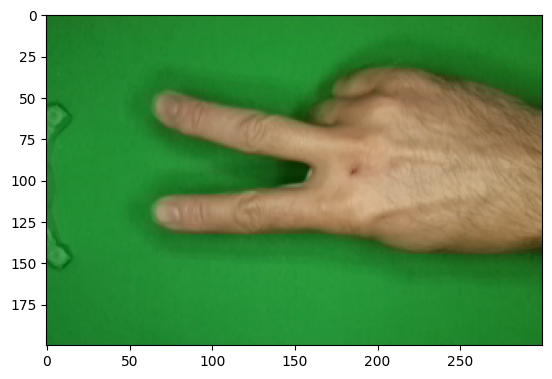

In [75]:
plt.figure()
folder = os.path.join('train', random.choice(['rock','paper','scissors']))
img_name = random.choice(os.listdir(folder))
img = io.imread(os.path.join(folder,img_name))
print( img.shape)
plt.imshow(img)
plt.show()

## Transformation and data augmentation

In [ ]:
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100,150)),
    transforms.ColorJitter(brightness=0.3,hue=0.3,saturation=0.3,contrast=0.2),
    #transforms.RandomPerspective(distortion_scale=0.1, p=0.2),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD),
])
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100,150)),
    transforms.ColorJitter(brightness=0.3,hue=0.3,saturation=0.3,contrast=0.2),
    transforms.RandomRotation(degrees=(-20,20)),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD),
])

gen_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100,150)),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD),
])

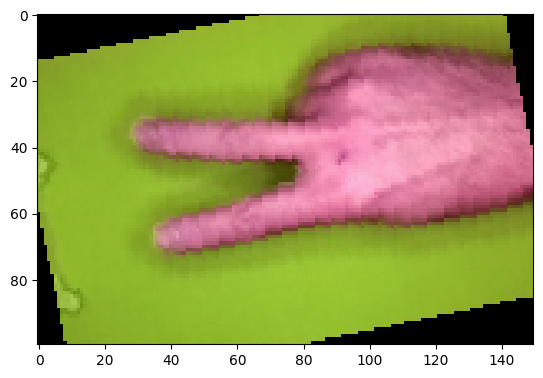

In [78]:
transformed_img = train_transform(img)
plt.imshow(unnormalize(transformed_img.permute(1,2,0).numpy()))
plt.show()

## DataLoader creation

In [ ]:
batch_size = 9
train_dataset = datasets.ImageFolder(root='train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='test', transform=test_transform)

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size)
print('Number of training batches: {}'.format(len(train_dl)))
print('Number of test batches: {}'.format(len(test_dl)))
classes = train_dataset.classes

show_batch(*next(iter(train_dl)), title='train')
show_batch(*next(iter(test_dl)), title='test')

Number of training batches: 219
Number of test batches: 25


## Training functions

In [76]:
def train_model(model, dataloaders,  criterion, optimizer, scheduler, num_epochs=25, verbose=True):
    stats = {
            'train_loss': [],
            'test_loss': [],
            'test_acc': [],
            'test_rec': [],
            'test_prec': [],
            'test_f1': [],
            'elapsed_time': 0,
            'best_accuracy':0,
            'best_loss': math.inf
    }
    for epoch in range(num_epochs):
        dl = dataloaders['train']
        if(verbose):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-'*10)
            dl = tqdm(dl,leave=False)


        # TRAIN
        running_loss = 0
        start_time = time.time()
        model.train()
        for batch_index, (images, labels) in enumerate(dl):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            running_loss += loss.item()*images.size(0)
            optimizer.step()
        stats['elapsed_time'] += time.time() - start_time
        epoch_loss = running_loss / len(dataloaders['train'])
        stats['train_loss'].append(epoch_loss)

        # test
        acc = Accuracy(task="multiclass",num_classes=len(classes)).to(device)
        precision = Precision(task="multiclass", num_classes=len(classes), average='macro').to(device)
        recall = Recall(task="multiclass", num_classes=len(classes), average='macro').to(device)

        model.eval()
        with torch.no_grad():
            running_loss = 0
            for images, labels in dataloaders['test']:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()*images.size(0)
                _, preds = torch.max(outputs, 1)
                acc(preds, labels)
                precision(preds, labels)
                recall(preds, labels)

            test_loss = running_loss / len(dataloaders['test'])
            test_accuracy = acc.compute()
            test_precision = precision.compute()
            test_recall = recall.compute()
            test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall) if (precision + recall)>0 else 0

            stats['test_loss'].append(test_loss)
            stats['test_acc'].append(test_accuracy.to('cpu'))
            stats['test_rec'].append(test_recall.to('cpu'))
            stats['test_prec'].append(test_precision.to('cpu'))
            stats['test_f1'].append(test_precision.to('cpu'))
            if(test_loss < stats['best_loss']):
                stats['best_loss'] = test_loss
                best_model = copy.deepcopy(model.state_dict())
                torch.save(best_model, 'best_model.pt')
            #if(test_accuracy > stats['best_accuracy']):
            #    stats['best_accuracy'] = test_accuracy
            #    best_model = copy.deepcopy(model.state_dict())
            #    torch.save(best_model, 'best_model.pt')

        if(verbose):
            print(f"Train loss: {epoch_loss:.4f}")
            print(f"Test loss: {test_loss:.4f}")
            print(f"Test accuracy: {test_accuracy:.4f}")
            print(f"Test precision: {test_precision:.4f}")
            print(f"Test recall: {test_recall:.4f}")
            print(f"F1 score: {test_f1:.4f}")

    model.load_state_dict(best_model)
    return stats

In [77]:
def cross_val(model_class, model_params, dataset,  criterion, optimizer_class, scheduler_class, lr=1e-3,num_epochs=25, k=5):
    kf = KFold(n_splits=k, shuffle=True)
    stats = {}

    for fold, (train_idx, val_idx) in tqdm(enumerate(kf.split(dataset))):
        # it is important to reinitialize the model
        net = model_class(*model_params)
        net.to(device)

        # Initialize optimizer and scheduler inside the loop for each fold
        optimizer = optimizer_class(net.parameters(), lr=lr) # Initialize optimizer
        scheduler = scheduler_class(optimizer, step_size=7, gamma=0.1) # Initialize scheduler

        # note that here the "random" means that the indices will be permuted each time
        # however they will always be the same, only their order will change e.g (0,1,2) - (1,0,2) - (2,0,1) -...
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_dl = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_dl = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

        st = train_model(net, {'train': train_dl, 'test': val_dl},  criterion, optimizer, scheduler, num_epochs=num_epochs, verbose=False)
        for s in st:
            if s not in stats:
                stats[s] = []
            stats[s].append(st[s])
        #plot_stats(st)
    return stats
        # plot_stats(s)

In [78]:
def nested_cv(model_class, hyperparams, dataset,  criterion, optimizer_class, scheduler_class, k_int=5, k_ext=5):
    grid = ParameterGrid(hyperparams)
    kf = KFold(n_splits=k_ext, shuffle=True)

    running_loss = 0
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_dl = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_dl = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)


        best_loss = math.inf
        best_params = None
        for theta in tqdm(grid):
            s = cross_val(model_class,theta['model_params'], dataset,  criterion, optimizer_class, scheduler_class, num_epochs=10, lr = theta['lr'], k=k_int)
            plot_stats(s, title=f"fold{fold} kernel size: {theta['model_params'][0]}, stride: {theta['model_params'][1]}, lr: {theta['lr']}")
            mean_loss = np.mean(s['best_loss'])
            if (mean_loss < best_loss):
                best_loss = mean_loss
                best_params = theta
        print(f"Best parameters: {best_params}")
        net = mobel_class()
        net = net.to(device)

        optimizer = optimizer_class(net.parameters(), lr=lr)
        scheduler = scheduler_class(optimizer, step_size=7, gamma=0.1)
        fold_stat = train_model(net, {'train': train_dl, 'test': val_dl},  criterion, optimizer, scheduler, num_epochs=num_epochs, verbose=False)
        print(f"Loss with best params: {fold_stat['best_loss']}")
        running_loss += fold_stat['best_loss']
        print(f"running loss:{running_loss}")

    print(f"expected min statrisk:{ running_loss/k_ext}")


## Network definition

In [71]:
class KissNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(25*37*3, 3)
    def forward(self, x):
        x = transforms.Resize((25,37))(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

In [72]:
class EzNet(nn.Module):
    def __init__(self, kernel_size=5, stride=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8,kernel_size=kernel_size,stride=stride,padding=1)
        self.conv2 = nn.Conv2d(8,16,kernel_size=kernel_size,stride=stride,padding=1)
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.LazyLinear(84)
        self.fc2 = nn.Linear(84,3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [73]:
class DeepNet(nn.Module):
    @staticmethod
    def block(conv_layers, channels, kernel_size):
        layers = []
        for _ in range(conv_layers):
            layers.append(nn.LazyConv2d(channels, kernel_size=kernel_size, padding=1))
            layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(2, 2))
        layers.append(nn.BatchNorm2d(channels))
        return nn.Sequential(*layers)

    def __init__(self, arch=((1, 12, 11), (2, 16, 5), (2, 32, 3))):
        super().__init__()
        
        self.convBlocks = nn.Sequential(
            *[self.block(conv, chan, ker) for conv, chan, ker in arch]
        )
        
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.convBlocks(x)
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [74]:
class SimpleNet(nn.Module):
    def __init__(self,starting_channels=16):
        super().__init__()
        self.conv1 = nn.Conv2d(3, starting_channels,kernel_size=10,stride=4,padding=1)
        self.conv2 = nn.Conv2d(starting_channels,starting_channels*2,kernel_size=5,stride=2,padding=1)
        self.conv3 = nn.Conv2d(starting_channels*2, starting_channels*4, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.LazyLinear(1024)
        self.fc2 = nn.Linear(1024,128)
        self.fc3 = nn.Linear(128,3)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.flatten(start_dim=1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


## Hyperparameter tuning
### EzNet with grid search and nested cross validation

In [ ]:
params = {
    'lr': [1e-3, 5e-4],
    'model_params': [(5,2),(3,2),(3,1)],
}
nested_cv(
    model_class=EzNet,
    hyperparams=params,
    dataset=train_dataset,
    criterion=nn.CrossEntropyLoss(),
    optimizer_class=optim.Adam,
    scheduler_class=lr_scheduler.StepLR,
    k_int=3,
    k_ext=3)

### DeepNet with cross validation

In [ ]:
params = {
    'lr': [1e-3],
    'model_params': [
        [((1, 8, 11), (2, 16, 5), (2, 32, 3))],
        [((2, 16, 3), (1, 32, 3), (1, 64, 3))],
        [((3, 16, 5), (2, 32, 5), (1, 64, 3))]
    ]
}

nested_cv(
    model_class=DeepNet, 
    hyperparams=params, 
    dataset=train_dataset, 
    criterion=nn.CrossEntropyLoss(), 
    optimizer_class = optim.Adam,
    scheduler_class = lr_scheduler.StepLR,
    k_int=3,
    k_ext=3)


## WideNet with nested cross validation

In [ ]:
params = {
    'lr': [1e-3],
    'model_params': [
        16,
        32,
        64
    ]
}

nested_cv(
    model_class=SimpleNet, 
    hyperparams=params, 
    dataset=train_dataset, 
    criterion=nn.CrossEntropyLoss(), 
    optimizer_class = optim.Adam,
    scheduler_class = lr_scheduler.StepLR,
    k_int=3,
    k_ext=3)

## Test of the best hyperparameter against test set

In [ ]:
times = {}

for model in [KissNet, DeepNet, EzNet, SimpleNet]:
    net = model()
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(net.parameters(), lr=1e-3)
    # An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    dls = {'train' : train_dl, 'test': test_dl}
    stats = train_model(net, dls, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)
    plot_stats(stats)
    print(stats['elapsed_time'])
    times[model.__name__] = stats['elapsed_time']
    cm_plot(net, test_dl)

plt.bar(times.keys(), times.values())
plt.show()


# K-Fold Cross Validation

In [ ]:
times = {}
tot_stats = {'train_loss':{},
             'test_acc':{},
             'test_acc':{},
             'test_prec':{},
             'test_rec':{}
             }
for model in KissNet, EzNet, SimpleNet, DeepNet:
    start_time = time.time()
    stats = cross_val(model, train_dataset, criterion, optim.Adam, lr_scheduler.StepLR, num_epochs=20, k=8)
    times[model.__name__] = time.time() - start_time
    plot_stats(stats, title=model.__name__)
    for s in tot_stats:
        tot_stats[s][model.__name__] = np.mean(stats[s], axis=0)
    print(tot_stats)

plt.bar( times.keys(), times.values())
plt.show()

In [ ]:
for s in tot_stats:
    for net in tot_stats[s]:
        plt.plot(tot_stats[s][net], label=net)
    plt.title(s)
    plt.legend()
    plt.show()

In [ ]:
for s in tot_stats:
    for net in tot_stats[s]:
        if (net!='KissNet'):
            plt.plot(tot_stats[s][net], label=net)
    plt.title(s)
    plt.legend()
    plt.show()

# Generalizing capabilities

In [ ]:
gen_test_dataset = datasets.ImageFolder(root='generalized_dataset', transform=gen_test_transform)
gen_test_dl = DataLoader(gen_test_dataset, batch_size=batch_size)
print('Number of test batches: {}'.format(len(gen_test_dl)))
show_batch(*next(iter(gen_test_dl)))

In [ ]:
times = {}
for model in [KissNet, DeepNet, EzNet, SimpleNet]:
    net = model()
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(net.parameters(), lr=1e-3)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    dls = {'train' : train_dl, 'test': gen_test_dl}
    stats = train_model(net, dls, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
    plot_stats(stats, title=model.__name__)
    print(stats['elapsed_time'])
    times[model.__name__] = stats['elapsed_time']
    cm_plot(net, gen_test_dl)

plt.bar(times.keys(), times.values())
plt.show()

In [ ]:
show_misclassified(net, gen_test_dl)